# OS-Task Scheduling

## 生成系统任务
如何生成系统tasks请参考论文[Techniques For The Synthesis Of Multiprocessor Tasksets](https://www.cs.york.ac.uk/rts/static/papers/R:Emberson:2010a.pdf)，对应Python版本的[代码](https://github.com/Hoseinkangavarnazari/RT_TaskGenerator_scheduler)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pprint import pprint

         U      T      C      S
array([[ 0.1 ,  4.  ,  0.4 ,  1.39],
       [ 0.  ,  6.  ,  0.02,  3.09],
       [ 0.21,  2.  ,  0.42,  0.48],
       [ 0.04,  5.  ,  0.18,  1.05],
       [ 0.1 ,  6.  ,  0.62,  0.57],
       [ 0.19, 10.  ,  1.86,  6.07],
       [ 0.06,  3.  ,  0.19,  2.78],
       [ 0.04,  4.  ,  0.17,  0.08],
       [ 0.03, 10.  ,  0.32,  3.95],
       [ 0.02,  8.  ,  0.19,  1.75]])
sum of eachU = 0.8


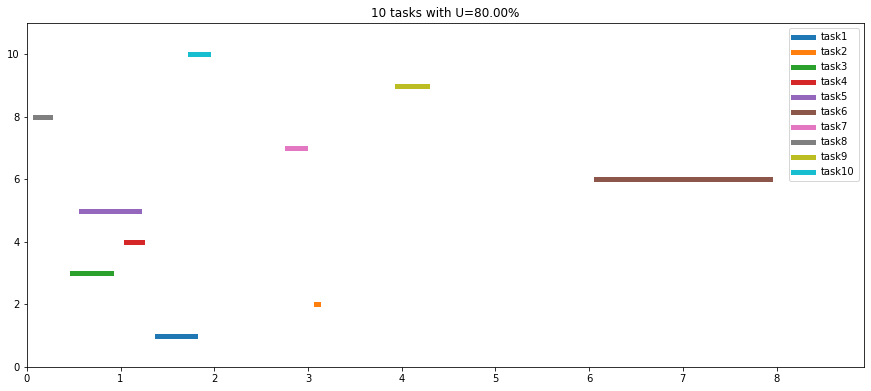

In [36]:
from numpy.random import randint, uniform


def GenerateTasks(n, tU, verbose=False, draw=False):
    """
    @n, number of tasks
    @tU, system utilization of generated tasks

    生成参数：[T, C, S, Bs, Es]
        @U: 任务系统占用率，U = uunifast(n, tU)_i
        @T: 任务周期，随机整数，[2, 10]
        @C: 任务运行时长，C = U*T，约束1
        @D: -
        @S: 任务启动时间，随机小数，[0, T-C)，约束2
        @Bs: 允许提前时间，随机小数，[0, S]，约束3
        @Es: 允许滞后时间，随机小数，[0, T-(C+S)]，约束4
    约束：
        1. U = C / T         任务系统占用率 = 运行时间 / 周期
        2. T - (C+S) > 0     周期 > 运行时长+启动时间
        3. S - Bs >= 0       启动时间 >= 提前时间
        4. T - (C+S+Es) > 0  周期 > 运行时长+启动时间+滞后时间
    """
    sumU = tU
    eachU = []
    for i in range(1, n):
        nextSumU = sumU * (uniform(0, 1)**(1/(n-i)))
        eachU.append(sumU-nextSumU)
        sumU = nextSumU
    eachU.append(sumU)
    eachU = np.array(eachU)
    eachT = randint(low=2, high=10+1, size=n)  # period
    eachC = eachT * eachU
    eachS = uniform(0, eachT-eachC)

    tasks = np.stack([eachU, eachT, eachC, eachS]).T
    if verbose:
        print('         U      T      C      S')
        pprint(np.round(tasks, 2))
        print('sum of eachU =', eachU.sum())
        
    if draw:
        plt.figure(figsize=(15, 3+np.log2(len(tasks))))
        for i, task in enumerate(tasks, 1):
            iC, iS = 2, 3
            plt.plot([task[iS], task[iC]+task[iS]], [i, i], linewidth=5, label='task%d'%(i))
        plt.ylim(0, len(tasks)+1)
        plt.xlim(0,(tasks[:,iC]+tasks[:,iS]).max()+1)
        plt.title('%d tasks with U=%.2f%%'%(n, tU*100))
        plt.legend()
        plt.show()
    return tasks

tasks = GenerateTasks(10, 0.8, verbose=True, draw=True)


| S1-Ei | S2-Ei  | S3-Ei  | S4-Ei  | S5-Ei  |
| :-: | :-: | :-: | :-: | :-: |
| b11 |	b21 | b31 | b41	| b51 |
| b12 |	b22 | b32 | b42	| b52 |
| b13 |	b23 | b33 | b43	| b53 |
| b14 |	b24 | b34 | b44	| b54 |
| b15 |	b25 | b35 | b45	| b55 |

对于任务1来说：
- 第一行：其他任务开始时间`Si` - 任务1结束时间`E1`。结果应该大于等于0。
- 第一列：任务1开始时间`S1` - 其他任务结束时间`Ei`。结果应该大于等于0。

只有其他任务同时违反了才是真的违反。例如`b21`和`b12`同时小于0时，任务1和2才冲突。

In [43]:
class OSTasks():
    iC = 2 # 任务运行时长所在列
    iS = 3 # 任务启动时间所在列
    
    def __init__(self, task_matrix):
        self.tm = task_matrix # task matrix
        self.optimizer = None
    
    @property
    def S(self):
        return self.tm[:, self.iS]

    @property
    def C(self):
        return self.tm[:, self.iC]

    def compute_cv(self, mask=None):
        """返回 constrain value"""
        S = self.S          # 开始时刻
        E = self.C + self.S # 结束时刻
        num = len(S)
        if not mask:
            mask = np.array([1] * 5, dtype=bool)
        
        matrix = np.tile(S, (num, 1)) # 复制num行
        matrix -= E.reshape(-1, 1)    # 行为Si - E；列为S-Ei
        
        # 选出违反这两条件的: 1. Si-E >= 0; 2. S-Ei >= 0
        # 1. 其他任务开始时间需要晚于当前任务结束时间
        # 2. 当前任务开始时间需要晚于其他任务结束时间
        bmatrix = matrix < 0
        cm = [bmatrix[i] & bmatrix[:,i] for i in range(num)]

        each_cv = [cm_row.sum(where=mask) for cm_row in cm]
        each_cv = np.subtract(each_cv, 1, where=mask) # 减去自己
        each_cv[~mask] = 0
        return each_cv.sum() / 2 

In [44]:
os_tasks = OSTasks(tasks)
os_tasks.compute_cv()

TypeError: bad operand type for unary ~: 'NoneType'

In [5]:
def calCV(cm, mask):
    """
        @cm: constrain matrix
    """
    #print(cm)
    each_cv = [cm_row.sum(where=mask) for cm_row in cm]
    each_cv = np.subtract(each_cv, 1, where=mask)
    each_cv[~mask] = 0
    print('each_cv:', each_cv)
    sum_cv = np.sum(each_cv) # constrain value
    return sum_cv
    
def TEST_constrain():
    Mask = np.array([1, 1, 0, 1, 1], dtype=bool)
    S = np.array([1, 3, 4, 5, 3])
    E = np.array([2, 4, 8, 6, 12])
    l = len(S)
    matrix = np.tile(S, (l, 1))
    matrix -= E.reshape(-1, 1)

    bmatrix = matrix < 0 # 选出违反条件的
    print('bmatrix:\n', bmatrix)
    cm = [bmatrix[i] & bmatrix[:,i] for i in range(l)]
    pprint(cm)
    cv = calCV(cm, Mask)
    
    print(cv)

TEST_constrain()

bmatrix:
 [[ True False False False False]
 [ True  True False False  True]
 [ True  True  True  True  True]
 [ True  True  True  True  True]
 [ True  True  True  True  True]]
[array([ True, False, False, False, False]),
 array([False,  True, False, False,  True]),
 array([False, False,  True,  True,  True]),
 array([False, False,  True,  True,  True]),
 array([False,  True,  True,  True,  True])]
each_cv: [0 1 0 1 2]
4


In [6]:
a = np.array([1, 2, 3, 4, 5, 6])
mask = np.array([1, 1, 1, 0, 0, 0], dtype=bool)

np.subtract(a, 1, where=mask)

array([                  0,                   1,                   2,
       4624633867356078080, 4624633867356078080, 4624633867356078080])

$\text{obj} = \sum_i^n x_i$

$\text{arg max}F(x)$

$\underset{x_i}{\arg \max } f(x_i) = \arg \max_x\ \sum x_i$


## 建立优化模型

In [7]:
import numpy as np
import geatpy as ea

class OSScheduling(ea.Problem):
    """
    variable:
        x_i: 每个任务是否被执行
    """
    def __init__(self):
        name = 'OS-Scheduling'
        M = 1             # 优化目标维数
        maxormins = [-1]  # 目标最小/最大化，1:min；-1:max
        Dim = 1           # 决策变量维数
        varTypes = [1] * Dim  # 决策变量类型，0:连续；1:离散
        lb = [0]          # 决策变量下界
        ub = [5]    
        lbin = [1]        # 决策变量下界类型，1包含边界，0不包含
        ubin = [1]  
        ea.Problem.__init__(self, name, M, maxormins, Dim,
                            varTypes, lb, ub, lbin, ubin)
    
    def readTasks(self, tasks):
        S = tasks[:,iS]
        E = tasks[:,iC] + S
        num = len(S)
        matrix = np.tile(S, (num, 1)) # 复制num行
        matrix -= E.reshape(-1, 1)    # 行为Si - E；列为-(Ei-S)

        # 选出违反这两条件的: 1. Si-E >= 0; 2. Ei-S <= 0
        # 1. 其他任务开始时间晚于当前任务结束时间
        # 2. 其他任务结束时间早于当前任务开始时间
        self.bmatrix = matrix < 0
    
    
    def calCV(cm, mask):
        """
            @cm: constrain matrix
        """
        #print(cm)
        each_cv = [cm_row.sum(where=mask) for cm_row in cm]
        each_cv = np.subtract(each_cv, 1, where=mask)
        each_cv[~mask] = 0
        #print(each_cv)
        sum_cv = np.sum(each_cv) # constrain value
        return sum_cv
        
    def aimFunc(self, pop):
        """目标函数
            @pop：传入的种群对象
        """
        Vars = pop.Phen    # 决策变量矩阵
        x1 = Vars[:, [0]]  # 变量x1组成的列向量
        #x2 = Vars[:, [1]]  
        #x3 = Vars[:, [2]]
        
        pop.ObjV = 4*x1 + 2*x2 + x3 # 目标函数值
        # 采用可行性法则处理约束，生成种群个体违反约束程度矩阵
        pop.CV = np.hstack([2*x1 + x2 - 1,  # 第一个约束
                            x1 + 2*x3 - 2,  # 第二个约束
                            np.abs(x1 + x2 + x3 - 1)])  # 第三个约束

# Backup

In [8]:
%%script true
import random
def generateTaskFromUtilization(UtilizationSet):
    taskList = []
    for i in range(len(UtilizationSet)):
        p = random.randint(2, 10) # period
        e = p * UtilizationSet[i] # in one hyper-period
        taskList.append([p, e])
    return taskList


def uunifast(n, tU):
    vectU = []
    sumU = tU
    for i in range(1, n):
        nextSumU = sumU * (random.uniform(0, 1)**(1/(n-i)))
        vectU.append(sumU-nextSumU)
        sumU = nextSumU
    vectU.append(sumU)
    AllSum = 0

    # summation over all utilization for finding global utilization
    for i in range(len(vectU)):
        AllSum += vectU[i]

    return AllSum, vectU


def uunifasts(N, n, tU):
    counter = 1
    while(counter <= N):
        Sum, Vect = uunifast(n, tU)
        # Because of rounding errors, utilization may not be same as given U
        # for example, 0.9999 is unacceptable when utilization(U) is equal to 1
        if(Sum == tU):
            # call function that makes the
            taskSet = generateTaskFromUtilization(Vect)
            counter += 1